This script tests the trained Gaussian process regression model on the month of August on the 10 intersections on which the model was trained. Thus, this script tests the model's forecast performance, since the model was trained using data sampled uniformly from May and July.

In [20]:
from __future__ import print_function
import warnings
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.close('all')
warnings.filterwarnings("ignore")

In [21]:
#%% Validation in terms of time: forecasting

filename = 'gprPedsMdl.pickle'
gprPedsMdl = pickle.load(open(filename, 'rb'))

filename = 'gprCycsMdl.pickle'
gprCycsMdl = pickle.load(open(filename, 'rb'))

filename = 'PedestriansData.sav'
Pedestrians = pickle.load(open(filename, 'rb'))

filename = 'CyclistsData.sav'
Cyclists = pickle.load(open(filename, 'rb'))

filename = 'testInts.sav'
testInts = pickle.load(open(filename, 'rb')) # Hold-out intersection IDs

testInts represents the hold-out intersections, thus the actual trained intersections are recovered as below:

In [22]:
#Extracting the intersections used for training
allInts = list(np.arange(0,14)) #all intersections
trainInts = list(set(allInts) - set(testInts)) #trained intersections

Pedestrians and traffic data are collected together in a list as below in order to separately test their performance:

In [23]:
RoadUser = ['Pedestrians', 'Cyclists']

trafficData = [Pedestrians, Cyclists]

gprMdls = [gprPedsMdl, gprCycsMdl] #Gaussian process regression models

Evaluating the performance for each of the 10 intersections on the month of July, for pedestrians and cylists

RMSE: 194.0749425694449
R_Squared: 0.5770719448723154


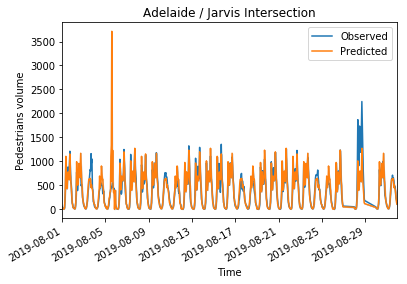

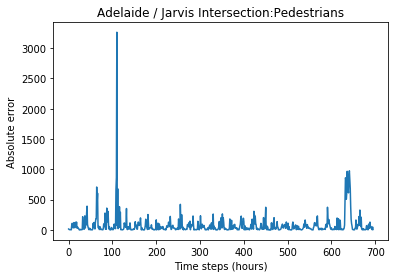

RMSE: 179.46249843228608
R_Squared: -0.9938632430700415


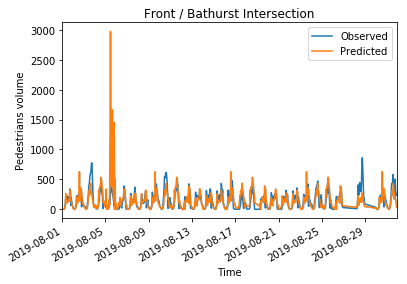

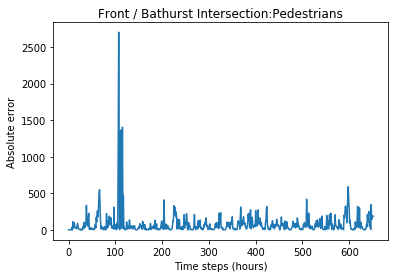

RMSE: 407.31449802818383
R_Squared: 0.7920631512598246


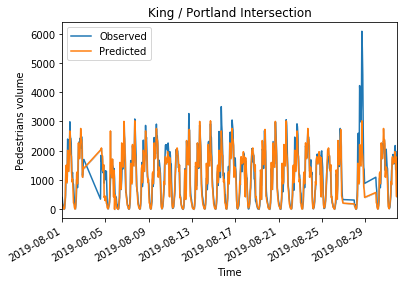

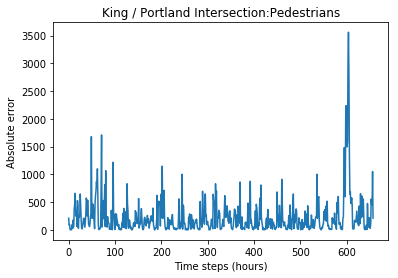

RMSE: 1216.337869680292
R_Squared: 0.7802286468520833


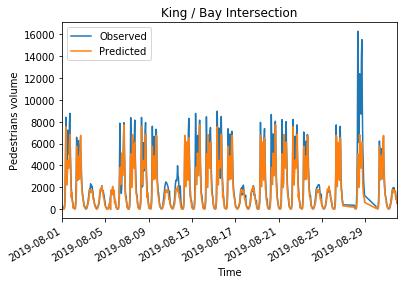

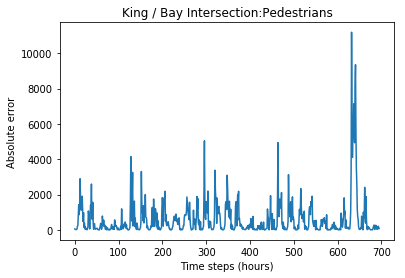

RMSE: 674.1192849524687
R_Squared: 0.8478787548640735


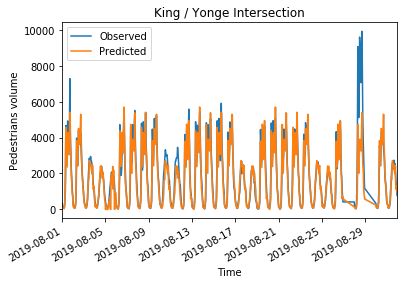

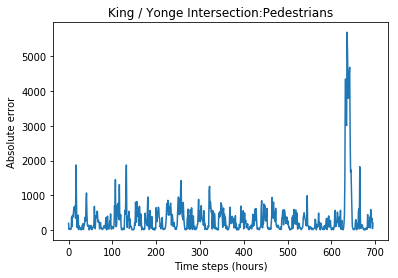

RMSE: 281.34428432409834
R_Squared: 0.8055195824986351


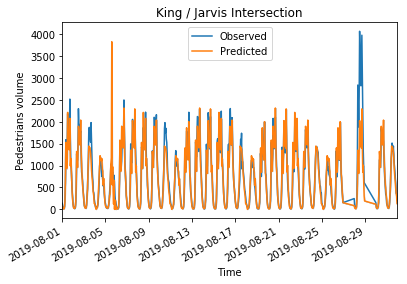

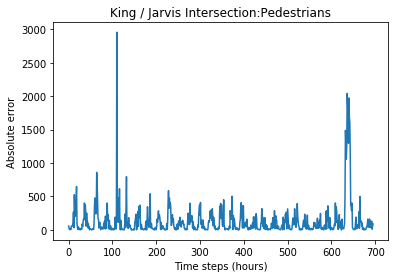

RMSE: 411.96634236473653
R_Squared: 0.8558456940634583


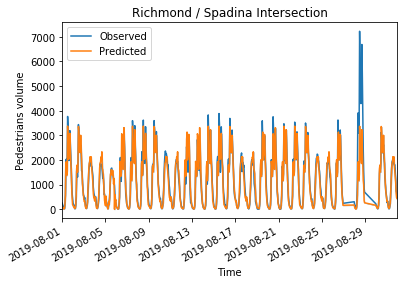

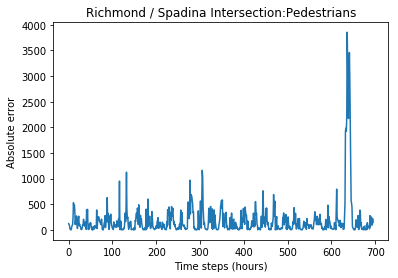

RMSE: 560.6566180745614
R_Squared: 0.8523660670652848


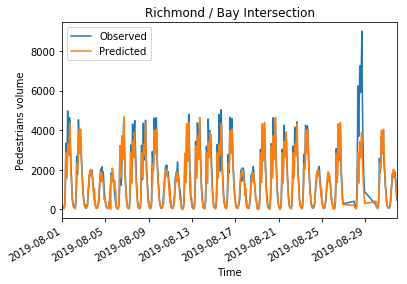

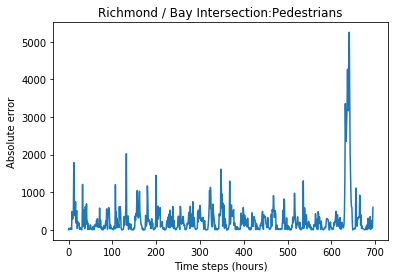

RMSE: 371.47197853369084
R_Squared: 0.6805314407787488


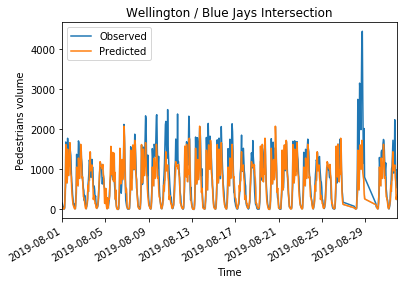

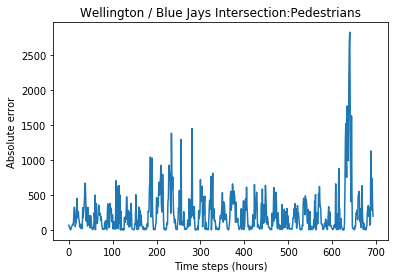

RMSE: 638.4552646818726
R_Squared: 0.816956371534086


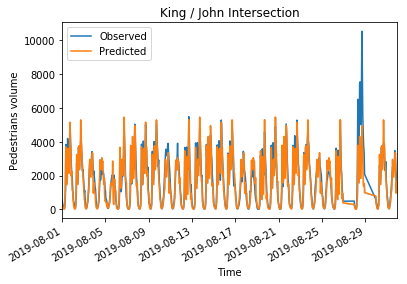

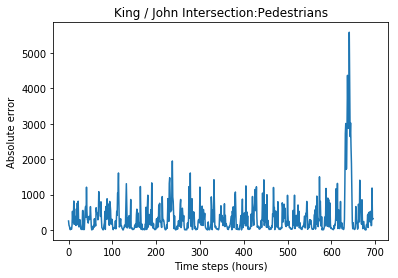

RMSE: 44.393553551154525
R_Squared: 0.20796556361209906


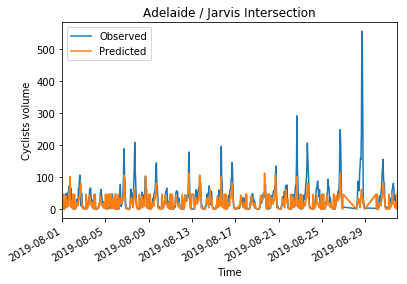

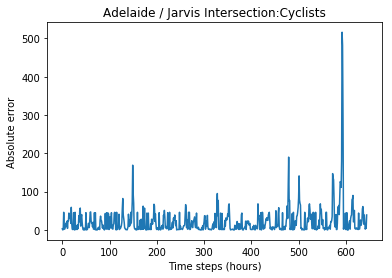

RMSE: 19.41176176562449
R_Squared: -0.22696058485109868


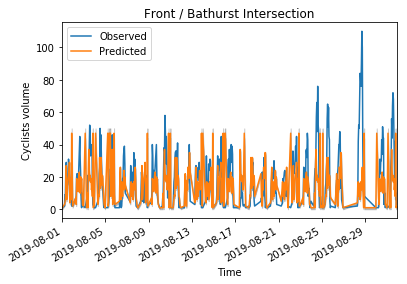

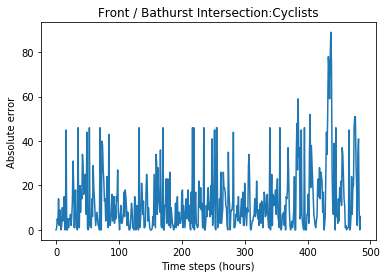

RMSE: 87.86156432166362
R_Squared: 0.3047911311182723


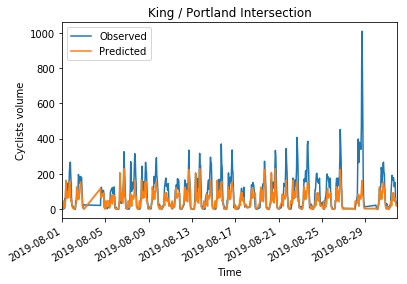

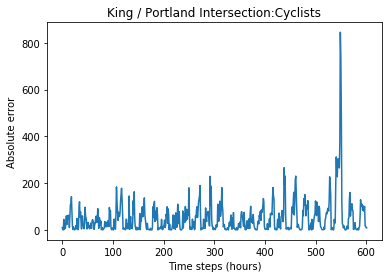

RMSE: 74.06063052570529
R_Squared: 0.24654154926119906


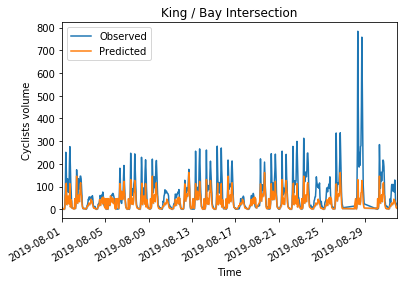

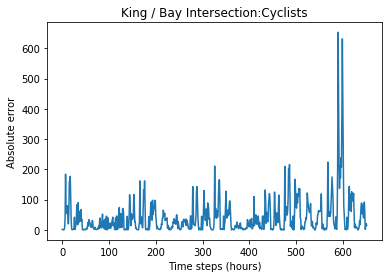

RMSE: 72.54853770118764
R_Squared: 0.40188976427088385


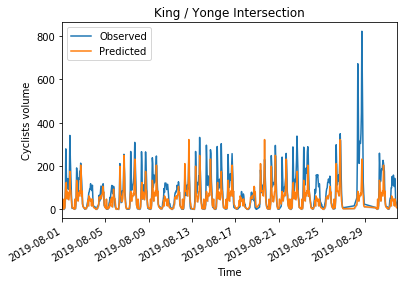

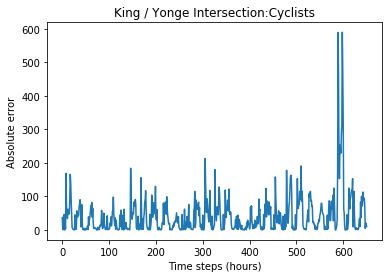

RMSE: 46.873154865645894
R_Squared: 0.5567807882820883


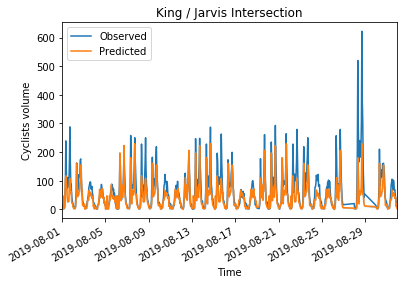

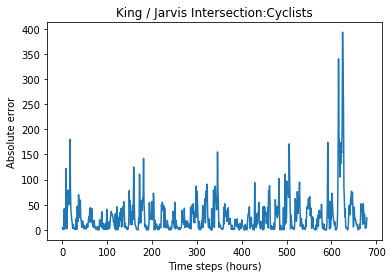

RMSE: 80.48538561314903
R_Squared: 0.17946616316676534


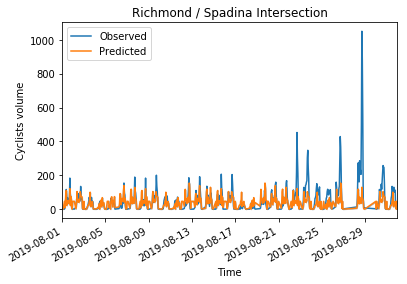

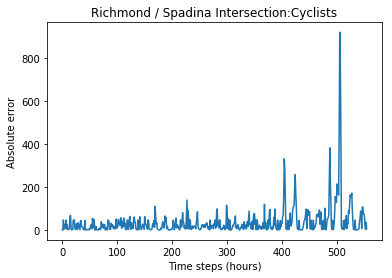

RMSE: 90.55867421517254
R_Squared: 0.5004851429826431


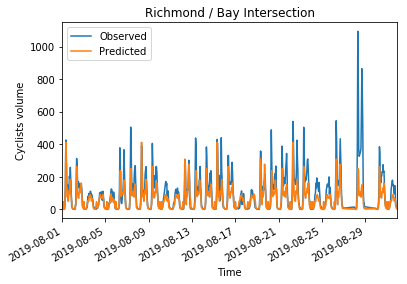

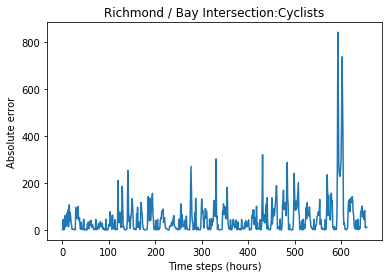

RMSE: 33.22286292133258
R_Squared: 0.13038140711758694


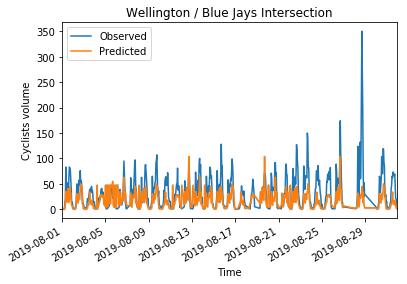

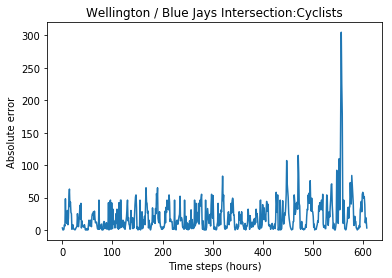

RMSE: 78.21940152401305
R_Squared: 0.37906543188118474


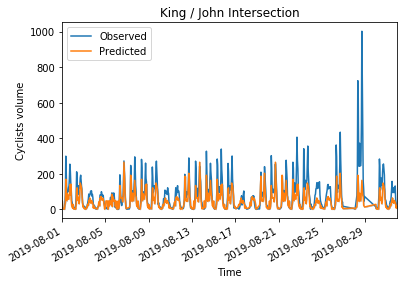

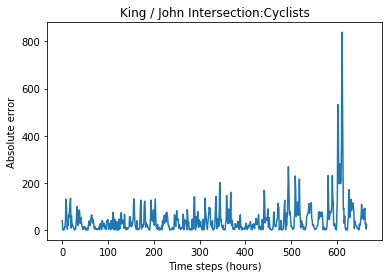

In [24]:
for j in range(2):
    
    gprMdl = gprMdls[j] #Selecting Gaussian process regression model 
    #for pedestrian or cyclists
    
    testData = trafficData[j]    
    
    for k in trainInts:
        
        testTraffic = testData[k];
        
        IntersectionName = testTraffic['IntName'][0]
        
        #Evaluating the hold-out set on the month of August for which 
        #the intersections were not trained for forecasting
        
        testStart = pd.to_datetime('2019-08-01 00:00:00');
        testEnd = pd.to_datetime('2019-08-31 23:00:00');
        
        testTraffic = testTraffic[testStart: testEnd]
            
        testTraffic = testTraffic.dropna()
        
        X_test = testTraffic[['Hour','DayOfWeek','isHoliday','lat','lng']];
        
        y_test = testTraffic['volume']
        
        yPred, yStd = gprMdl.predict(X_test, return_std = True)
        yPred = yPred.astype('int'); yPred[yPred<0]=0
        
        yPred = pd.DataFrame(yPred, columns =['forecast']); 
        yPred.index = y_test.index; yPred = yPred['forecast'];
        
        print('RMSE: '+str(np.sqrt(np.mean((yPred.values - y_test.values)**2))))
        print('R_Squared: '+str(gprMdl.score(X_test, y_test)))
        
        #Plus/minus 3 times the standard deviation is used in order to show the 99.7% confidence bound 
        #of the predictions
        yLow = yPred - 3*yStd; yLow = yLow.astype('int'); yLow[yLow<0]=0
        yHigh = yPred + 3*yStd; yHigh = yHigh.astype('int');

        #Plotting for the month of August               
        ax = y_test.plot(label = 'Observed')
        yPred.plot(ax = ax, label = 'Predicted')
        ax.fill_between(y_test.index,
                            yLow,
                            yHigh, color='k', alpha=.2)
        ax.set_xlabel('Time')
        ax.set_ylabel(RoadUser[j] + ' volume')
        ax.set_title(IntersectionName + ' Intersection')
        plt.legend()
        plt.show()
        
        #Showing the evolution of the forecast error in time
        AbsErr = np.abs(yPred.values - y_test.values)
        plt.plot(AbsErr); 
        plt.xlabel('Time steps (hours)'); plt.ylabel('Absolute error')
        plt.title(IntersectionName + ' Intersection:' + RoadUser[j])
        plt.show()